# Проект "проверка гипотез для интернет-магазина"

#  [Введение](#back)
<a id='start'></a>

Мы в роле аналитиков крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.
Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

Для выполнения проекта необходимо сделать следующие шаги:


1. Приоритизация гипотез.

Применим фреймворки ICE и RICE для приоритизации гипотез. Оценим, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясним, почему это произошло. 


2. Проведем анализ A/B-теста


- Построим график кумулятивной выручки по группам. 
- Построим график кумулятивного среднего чека по группам. 
- Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 
- Построим график кумулятивной конверсии по группам. 
- Построим график относительного изменения кумулятивной конверсии группы B к группе A. 
- Построим точечный график количества заказов по пользователям. 
- Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.
- Построим точечный график стоимостей заказов. 
- Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.
- Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. 
- Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 
- Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. 
- Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 
- Сделаем выводы и предположения для КАЖДОГО пункта анализа.
- Примем решение по результатам теста и объясним его. 

#   [Оглавление](#back)
<a id='back'></a>
- [Введение](#start)
- [Общая информация и предобработка данных](#info)
- [Приоретизация гипотез](#prioritization)
- [Анализ A/B-теста](#analit)
- [Общий вывод](#end)

#  [Общая информация и предобработка данных](#back)
<a id='info'></a>

In [1]:
#импортируем необхоимые библиотеки
import pandas as pd 
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy.stats as stats
from datetime import datetime, timedelta

#cразу сделаем графики чуть больше и красивее
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7 
sns.set_style("darkgrid")

#сохраним данные
visitors = pd.read_csv('visitors.csv')
orders = pd.read_csv('orders.csv')
hypothesis = pd.read_csv('hypothesis.csv')
    


### Датафрейм visitors

Оценим данные:

In [2]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [3]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Приведем обозначения групп к верхнему регистру, а столбец с датами к нужному типу:


In [4]:
visitors['group'] = visitors['group'].str.upper()
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Оценим наличие дубликатов:

In [5]:
print(visitors.duplicated().sum())
print(visitors.isna().sum())

0
date        0
group       0
visitors    0
dtype: int64


Посмотрим на измененные данные:

In [6]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [7]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


### Датафрейм orders

Оценим данные:

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Привдем названия и столбец с датами к удобному виду:

In [10]:
orders = orders.rename(columns={"transactionId": "transaction_id", 
                                "visitorId": "visitor_id"})
orders['group'] = orders['group'].str.upper()
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Ищем дубликаты:

In [11]:
print(orders.duplicated().sum())
print(orders.isna().sum())

0
transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64


Проверяем:

In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [13]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Данные чистые, посмотрим на  них внимательнее. Оценим группы на к-во участников, их пересечение и на период проведения теста:

Посмторим на даты начала и окончания теста:

In [14]:
orders["date"].describe(datetime_is_numeric=True)

count                             1197
mean     2019-08-15 13:06:46.015037696
min                2019-08-01 00:00:00
25%                2019-08-08 00:00:00
50%                2019-08-15 00:00:00
75%                2019-08-23 00:00:00
max                2019-08-31 00:00:00
Name: date, dtype: object

Даты в порядке, посмотрим на число уникальных участников:

In [15]:
orders['visitor_id'].nunique()

1031

И на к-во участников по группам:

In [16]:
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

Группа B немного больше группы А, но это не критично. Однако в сумме обе группы дают больше пользователей, чем должно быть, если судить по уникальным значениям. Значит - некоторые пользователи попали в обе группы. 

In [17]:
orders_a=orders.query('group == "A"')
orders_b=orders.query('group == "B"')
orders_both = pd.merge(orders_a, orders_b, how='inner', on='visitor_id')
orders_both_list=orders_both['visitor_id'].unique()
print(orders_both_list)

[4069496402  199603092 3803269165 2378935119  237748145 4256040402
 2038680547 1738359350 2458001652 3891541246 2716752286 3656415546
 2686716486 2954449915 2927087541 3234906277  457167155 2579882178
 3957174400 1648269707 2780786433  818047933 2044997962 1959144690
 3202540741 1333886533  351125977 3951559397  393266494 3984495233
 4120364173 4266935830 1230306981 1294878855 1614305549    8300375
  477780734 1668030113 3717692402 3766097110 3941795274  471551937
 1316129916 1801183820 1602967004 2587333274 2600415354  232979603
 3972127743 1404934699  276558944 3062433592 2654030115 3963646447
 4186807279 2712142231 2949041841  963407295]


Пользователи в этом списке (58 человек) попали в оба сегмента. Стоит избавиться от них для большей точности.

In [18]:
#orders = orders.query('visitor_id not in @orders_both_list')

### Датафрейм hypothesis

Оцениваем данные:

In [19]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [20]:
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Приводим данные к удобному виду:

In [21]:
hypothesis = hypothesis.rename(str.lower, axis='columns')
hypothesis['hypothesis'] = hypothesis['hypothesis'].str.lower()

Проверяем дубликаты:

In [22]:
print(hypothesis.duplicated().sum())
print(hypothesis.isna().sum())

0
hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64


Проверяем изменения:

In [23]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [24]:
hypothesis.head(10)

,hypothesis,reach,impact,confidence,efforts
0,"добавить два новых канала привлечения трафика,...",3,10,8,6
1,"запустить собственную службу доставки, что сок...",2,5,4,10
2,добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"изменить структура категорий, что увеличит кон...",8,3,3,8
4,"изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,показать на главной странице баннеры с актуаль...,5,3,8,3
7,добавить форму подписки на все основные страни...,10,7,8,5
8,"запустить акцию, дающую скидку на товар в день...",1,9,9,5


### Вывод:

- Данные просмотренны и приведены к общему стилю: строчные буквы, змеиный шрифт в названиях столбцов.
- Изменены типы данных для параметров времени.
- Пропуски и дубликаты отсутствуют.
- Во всех датафреймах данные в хорошем состоянии

#  [Приоретизация гипотез](#back)
<a id='prioritization'></a>

Приоритизируем гипотезы фреймворками ICE и RICE. Сравним результат:

In [25]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts']

data_ice = pd.DataFrame()
data_ice = data_ice.assign(hypothesis = hypothesis['hypothesis'], ICE = hypothesis['ICE'])
data_ice = data_ice.sort_values(by='ICE', ascending=False)
print(data_ice)

                                          hypothesis        ICE
8  запустить акцию, дающую скидку на товар в день...  16.200000
0  добавить два новых канала привлечения трафика,...  13.333333
7  добавить форму подписки на все основные страни...  11.200000
6  показать на главной странице баннеры с актуаль...   8.000000
2  добавить блоки рекомендаций товаров на сайт ин...   7.000000
1  запустить собственную службу доставки, что сок...   2.000000
5  добавить страницу отзывов клиентов о магазине,...   1.333333
3  изменить структура категорий, что увеличит кон...   1.125000
4  изменить цвет фона главной страницы, чтобы уве...   1.000000


Наиболее перспективные гипотезы 8, 0, 7, 6, 2

In [26]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts']

data_rice = pd.DataFrame()
data_rice = data_rice.assign(hypothesis = hypothesis['hypothesis'], RICE = hypothesis['RICE'])
data_rice = data_rice.sort_values(by='RICE', ascending=False)
print(data_rice)

                                          hypothesis   RICE
7  добавить форму подписки на все основные страни...  112.0
2  добавить блоки рекомендаций товаров на сайт ин...   56.0
0  добавить два новых канала привлечения трафика,...   40.0
6  показать на главной странице баннеры с актуаль...   40.0
8  запустить акцию, дающую скидку на товар в день...   16.2
3  изменить структура категорий, что увеличит кон...    9.0
1  запустить собственную службу доставки, что сок...    4.0
5  добавить страницу отзывов клиентов о магазине,...    4.0
4  изменить цвет фона главной страницы, чтобы уве...    3.0


Наиболее перспективные гипотезы 7, 2, 0, 6, 8.
Выведем эти гипотезы и сравним параметры:

In [27]:
hypothesis.sort_values(by='RICE', ascending=False).head()

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
2,добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
0,"добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
6,показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
8,"запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2


Вывод:
- Среди самых популярных гипотез - 0, 2, 6, 7, 8
- Для разных фреймворков приоретет меняется: для ICE порядок - 8, 0, 7, 6, 2, для RICE - 7, 2, 0, 6, 8
- При оценки параметров выясняется, что параметр REACH для седьмой и второй гипотезы очень большой - 10 и 8, против 3 и 1 для нулевой и восьмой гипотез. Он и вносит существенные изменения в приоретизации гипотез.
- Из-за большего охвата для 7 и 2 гипотез приоретизация фреймворком RICE поставила данные гипотезы на первые места. Не смотря на то, что REACH 6 гипотезы выше, чем 0 и 8, остальные параметры не позволили этой гипотезе подняться выше. 
- Скорее всего для первоначальной проверки лучше всего подходят 7 и 2 гипотезы.

- Помня о том, что RICE(reach, impact, confidence, effort) учитывает охват пользователей, в отличии от ICE - для первоначальной проверки лучше всего подходят 7 и 2 гипотезы.

#  [Анализ A/B-теста](#back)
<a id='analit'></a>

Соберем все кумулятивные данные для удобства построения графиков:

In [28]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].
    agg({'date' : 'max', 
         'group' : 'max', 
         'transaction_id' : 'nunique', 
         'visitor_id' : 'nunique', 
         'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные данные по дням данные о посетителях интернет-магазина 
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].
    agg({'date' : 'max', 
         'group' : 'max', 
         'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulative_data.head(5)) 


        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


Соберем датафреймы с кумулятивным количеством заказов и кумулятивной выручкой по дням в обеих группах. Построим графики выручки:

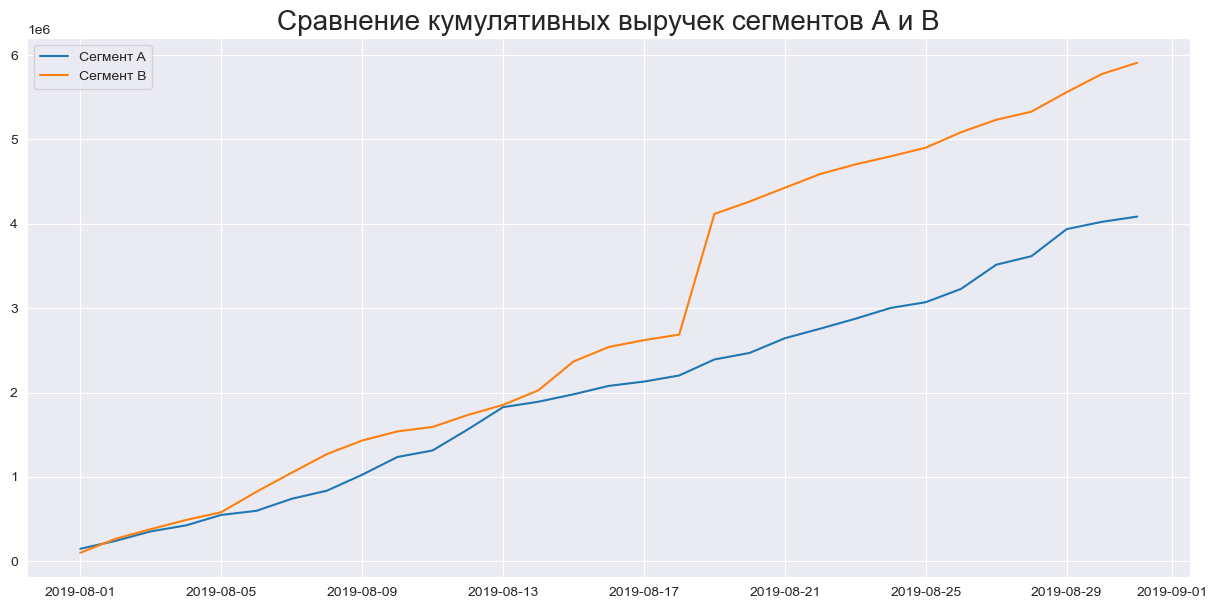

In [29]:
# создаем датафрейм с кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# создаем датафрейм с кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='Сегмент A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='Сегмент В')
plt.title('Cравнение кумулятивных выручек сегментов А и B', fontsize = 20)
plt.legend();

#### Вывод:
- Практически с самого начала сегмент B немнго обгонял сегмент А. 
- 13 числа выручка почти сравнялась. 
- Примерно в середине теста для сегмента B заметен резкий скачок. Это может быть обсуловленно крупными заказами в эти дни.
- После 19 числа выручка сегментов растет примерно одинаковыми темпами.

Поищем курпные заказы в промежутке 17-20 чисел:

In [30]:
# посмотрим на количесвто заказов для 17-20 августа. 
cumulative_revenue_b.query('"2019-08-17" <= date <= "2019-08-20"')

,date,revenue,orders
33,2019-08-17,2620790,373
35,2019-08-18,2686621,382
37,2019-08-19,4116541,403
39,2019-08-20,4263815,423


Число заказов примерно одинаковое - выведем самые большие заказы в эти дни.

In [31]:
orders.query('"2019-08-17" <= date <= "2019-08-20"').sort_values(by='revenue', ascending=False).head()

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
530,3970235543,2912540959,2019-08-19,43990,A
751,348143148,689129267,2019-08-20,37150,B
527,1570513684,2837914161,2019-08-19,33405,B
421,3765974140,1357170471,2019-08-19,31680,A


Очевидно, что 19 числа был совершен крупный заказ - около 1.3 миллиона, тогда как на втором месте около 44 тысяч. Это скачок мы и увидели на графике. 

Построим графики кумулятивного среднего чека по дням:

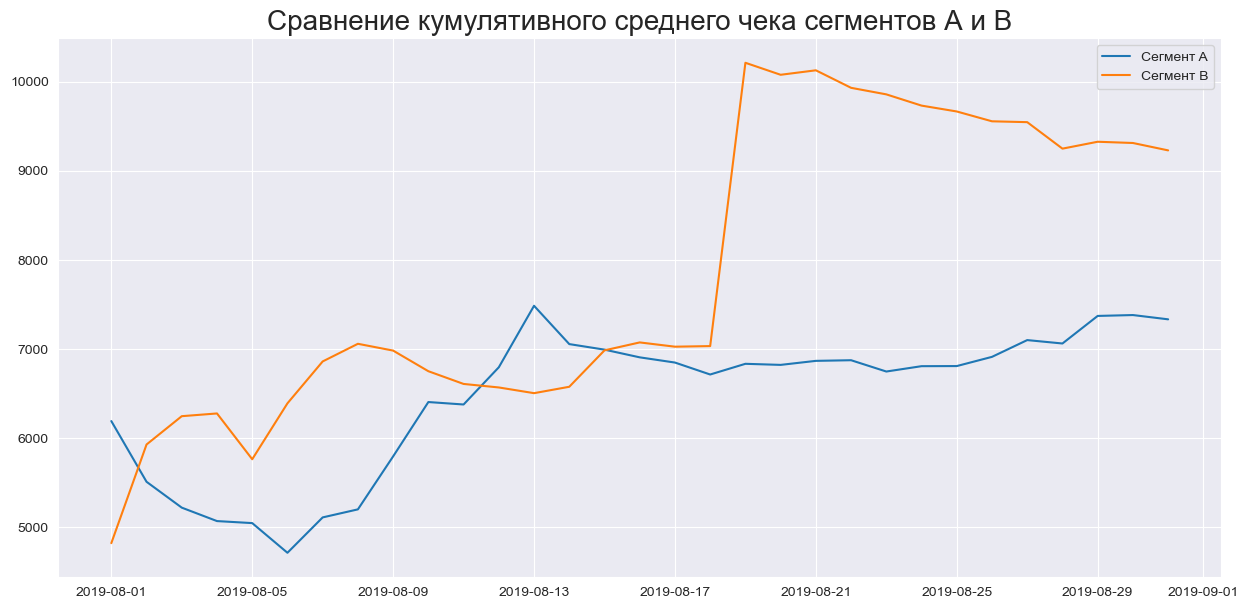

In [32]:
# делим кумулятивную выручку на число заказов:
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='Сегмент A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='Сегмент B')
plt.title('Cравнение кумулятивного среднего чека сегментов А и B', fontsize = 20)
plt.legend();

#### Выводы:
- Кумулятивные значения колеблются. 
- В начале средний чек сегмента А выше и резко снижается.
- Срежний чек сегмента B практически сразу становится больше и остается таким до всплеска около 13 числа (мы видели это в графике кумулятивных выручек в виде сближения кривых).
- Виден резкий скачок сегмента B во второй половине теста, связанный с крупным заказом 19 числа. 
- После 19 числа чек сегмента B постепенно снижается, а сегмента А наоборот - растет.

Посмотрим как меняется кумулятивный средний чек от группы B к группе А:

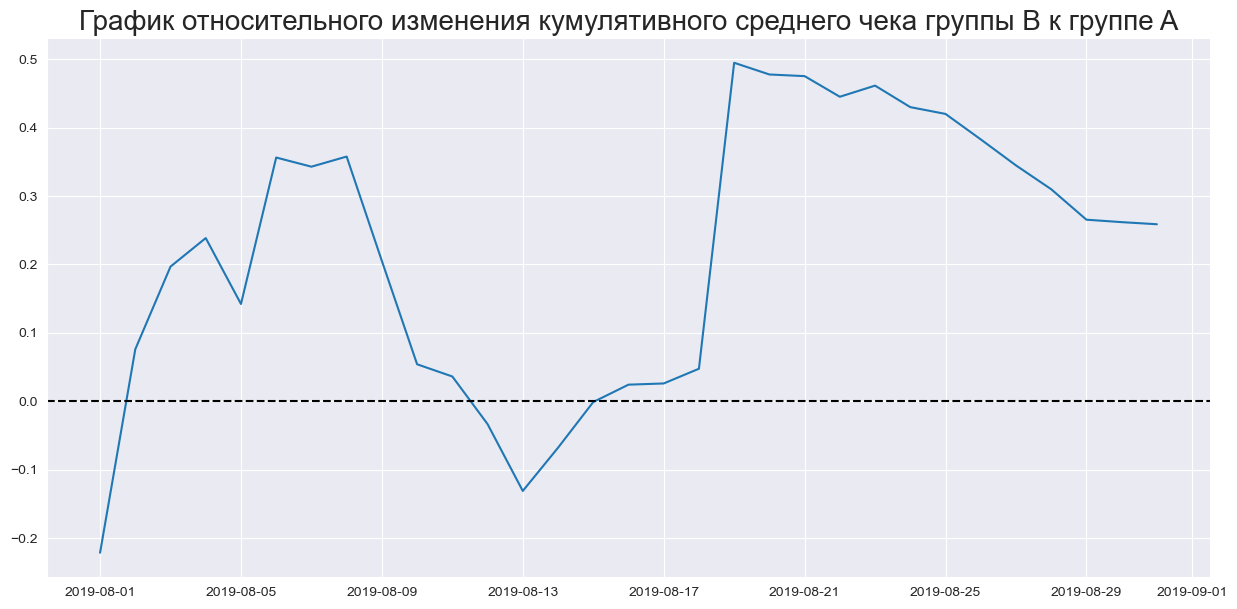

In [33]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(
    cumulative_revenue_b, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['_a', '_b'])
# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'], 
         (merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['orders_b'])/(merged_cumulative_revenue['revenue_a']/merged_cumulative_revenue['orders_a'])-1)

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize = 20)
plt.axhline(y=0, color='black', linestyle='--');

#### Выводы:
- Средний чек сегмента B рос с начала анализа и примерно до 7 августа. 
- Второго числа чек сегмента B привысил чек сегмента А.
- Падение среднего сека сегмента B началось около 8 числа и продолжалось до 13. 
- Около 13 числа сегмент B начал расти и вновь обогнал чек А. 
- 19 числа отмечаем резкий скачок среднего чека B, связанный с крупным заказом.
- После этого средний чек сегмента B постепенно приближается к среднему чеку сегмента А.
- График не противоречит логике прошлого графика. 

Построим график кумулятивной конверсии по группам:

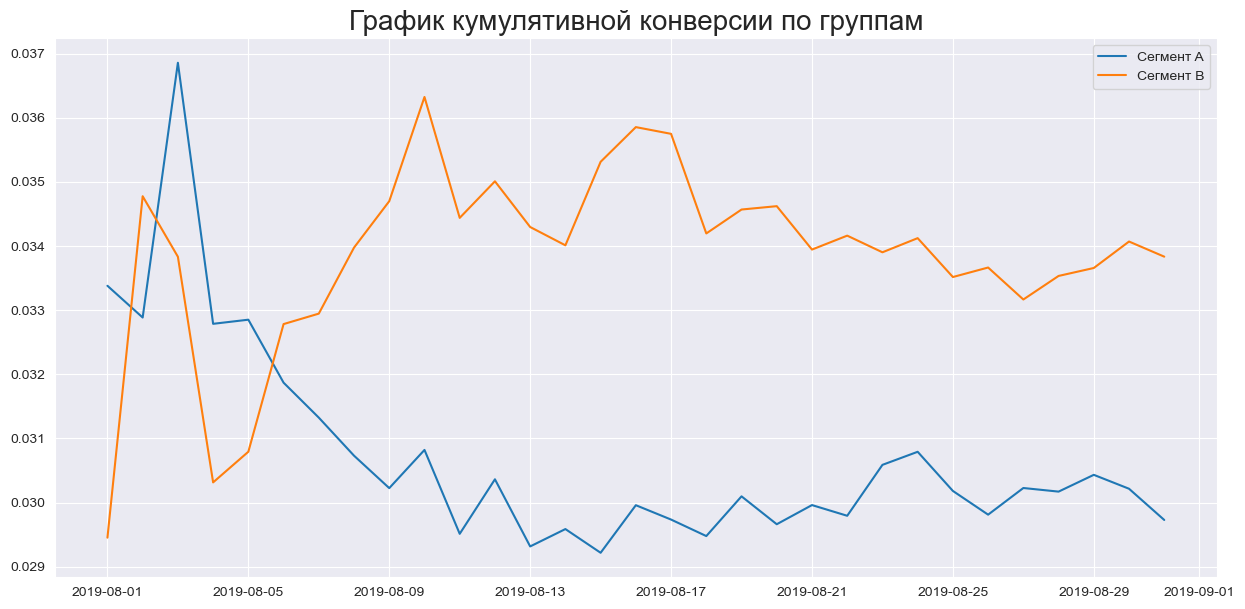

In [34]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='Сегмент A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='Сегмент B')
plt.title('График кумулятивной конверсии по группам', fontsize = 20)
plt.legend();



#### Выводы:
- В начале августа конверсия сегмента А была выше. 
- Около 3-го числа конверсия сегмента А достигла максимума и начала падать. Конверсия сегмента B также падала. 
- Падение конверсии сегмента В закончилась в районе 4-го числа и начала расти, конверсия сегмента А продолжила падение.
- Около 6 числа конверсия сегмента В привысила конверсию сегмента А
- После этого конверсии обоих сегментов, колебаясь, держаться на примерно одинаковом уровне (в диапазоне 0.033 - 0.036, падая со временем для сегмента В и в диапазоне 0.031-0.029 сегмента А). 
- Большую часть времени конверсия сегмента В выше, чем сегмента А

Построим график относительного изменения кумулятивной конверсии группы B к группе A:

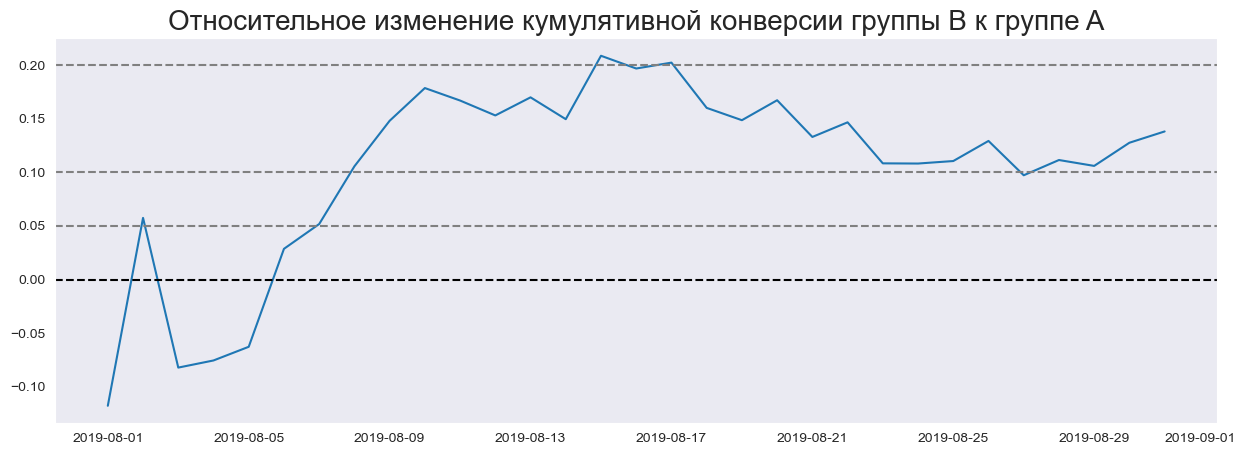

In [35]:
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(
    cumulative_data_b[['date','conversion']], 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['_a', '_b'])

plt.figure(figsize=(15,5))
plt.grid()
plt.plot(merged_cumulative_conversions['date'], 
         merged_cumulative_conversions['conversion_b']/merged_cumulative_conversions['conversion_a']-1 )

plt.title('Относительное изменение кумулятивной конверсии группы B к группе A', fontsize = 20)

plt.axhline(y=0, color='black', linestyle='--') 
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axhline(y=0.05, color='grey', linestyle='--');

#### Выводы:
- Конверсия сегмента В изначально была ниже конверсии сегмента А.
- Около 3-го числа наблюдался скачок конверсии, привысивший конверсию сегмента А. 
- Устойчивый рост конверсии В наблюдался с 4-го числа. 
- Отметку в 10% отношение конверсий привысило около 8 числа. 
- Отношение конверсии сохраняется на уровне 10-20% в пользу сегмента В.
- График не противоречит логике прошлого графика. 

Построим точечный график количества заказов по пользователям.

In [36]:
# найдем число заказов по пользователем:
orders_by_users = (orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'}))
orders_by_users.columns = ['visitor_id', 'orders']
orders_by_users.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


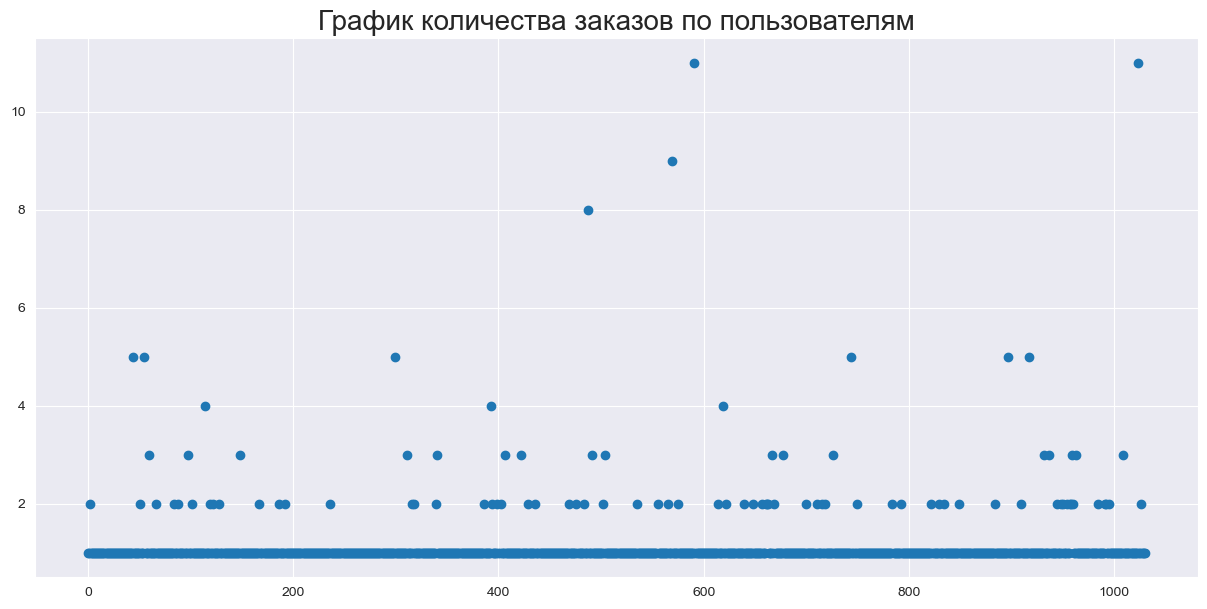

In [37]:
# построим график количества заказов по пользователям
x_values = pd.Series(range(0,len(orders_by_users)))
plt.title('График количества заказов по пользователям', fontsize = 20)
plt.scatter(x_values, orders_by_users['orders']);

#### Выводы:
- Подовляющее число пользователей совершило всего один заказ
- Пользователей, совершивших 2 заказа меньше
- Каждый следующий заказ соврешают все меньше пользователей - больше 5 заказов соверщили всего несколько пользователей. 

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя:

In [38]:
print(np.percentile(orders_by_users['orders'], [95,99])) 

[2. 4.]


#### Выводы:
- Больше 95% пользователей совершают всего 2 покупки.
- 4 и больше покупок совершает только 1% пользователей.
- Границу аномальных заказов выберем по 95-й процентали - т.е. больше двух заказов.

Построим точечный график стоимостей заказов по пользователям. 

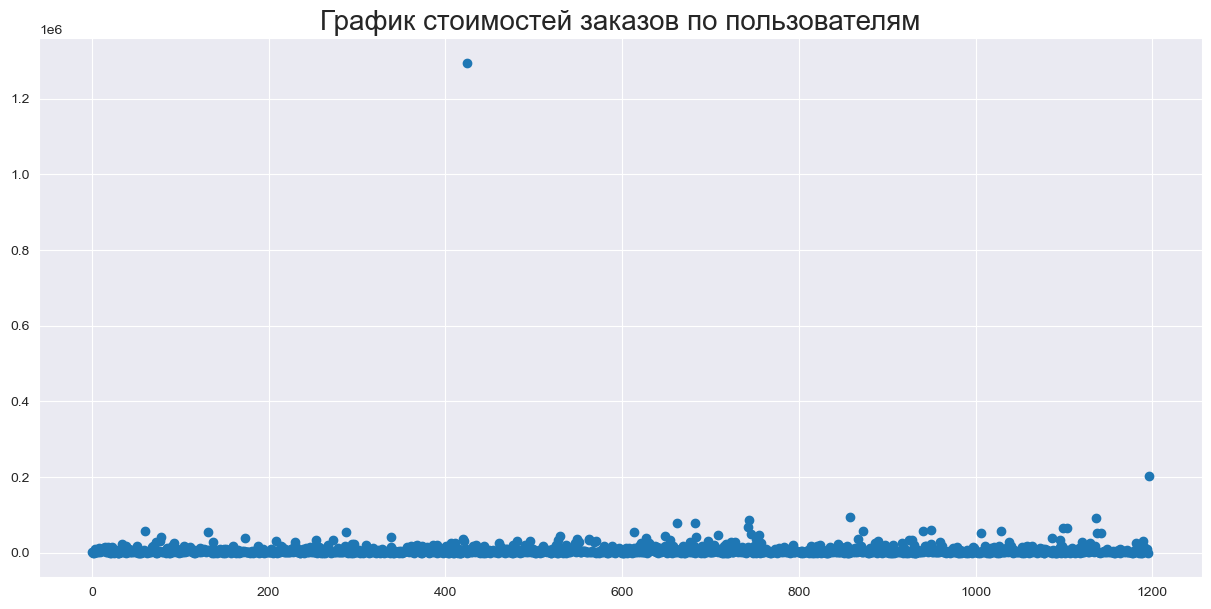

In [39]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.title('График стоимостей заказов по пользователям', fontsize = 20)
plt.scatter(x_values, orders['revenue']);

Очевидно, что найденный нами заказ в 1.3 миллиона сильно искажает картину. Уберем его и заказ в 200000 и посмотрим на остальные заказы:

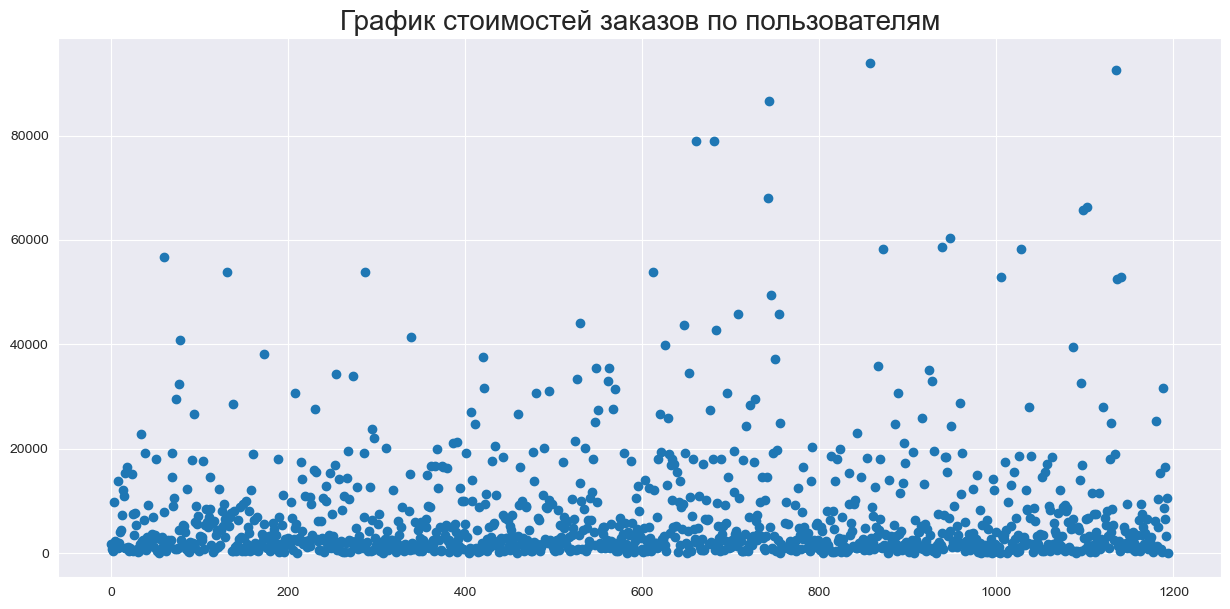

In [40]:
orders_without_heist_price = orders.query('revenue <= 200000')
x_values = pd.Series(range(0, len(orders_without_heist_price['revenue'])))
plt.title('График стоимостей заказов по пользователям', fontsize = 20)
plt.scatter(x_values, orders_without_heist_price['revenue']);

#### Выводы:
- Заказы в 1.3 миллиона и 200000 - единичные случаи.
- Большинство заказов меньше 20000.
- Отдельные заказы могут быть больше 60000, но практически не достигают 100000.

Найдем 95-й и 99-й перцентили стоимости заказов:

In [41]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


#### Выводы:
- 95% заказов меньше 30 тысяч.
- Всего 1% заказов выше 58 тысяч.
- Отбросим заказы выше 95 процнетали.

Подготовим данные для дальнеших расчетов

In [42]:
# подготовим данные

# число пользователей в выбранную дату в группе A:
visitors_a_daily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']
# количество пользователей до выбранной даты включительно в группе A:
visitors_a_cummulative = visitors_a_daily.apply(lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 
                                                 'visitors_per_date_a' : 'sum'}), axis=1)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

# число пользователей в выбранную дату в группе B:
visitors_b_daily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']
# количество пользователей до выбранной даты включительно в группе B:
visitors_b_cummulative = visitors_b_daily.apply(lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 
                                                 'visitors_per_date_b' : 'sum'}), axis=1)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

#  количество заказов и суммарная выручка в выбранную дату в группе A:
orders_a_daily = orders[orders['group']=='A'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transaction_id' : pd.Series.nunique, 
          'revenue' : 'sum'})
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']
# суммарное число заказов и суммарная выручка до выбранной даты включительно в группе A:
orders_a_cummulative = orders_a_daily.apply(
    lambda x: \
        orders_a_daily[orders_a_daily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'orders_per_date_a' : 'sum',
                'revenue_per_date_a' : 'sum'}), axis=1).sort_values(by=['date'])

orders_a_cummulative.columns = ['date', 'orders_cummulative_a', 'revenue_cummulative_a']

#  количество заказов и суммарная выручка в выбранную дату в группе B:
orders_b_daily = orders[orders['group']=='B'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transaction_id' : pd.Series.nunique, 
          'revenue' : 'sum'})
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']
# суммарное число заказов и суммарная выручка до выбранной даты включительно в группе B:
orders_b_cummulative = orders_b_daily.apply(
    lambda x: \
        orders_b_daily[orders_b_daily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'orders_per_date_b' : 'sum',
                'revenue_per_date_b' : 'sum'}), axis=1).sort_values(by=['date'])
orders_b_cummulative.columns = ['date', 'orders_cummulative_b', 'revenue_cummulative_b']

# соберем данные в одну таблицу
data = orders_a_daily.merge(orders_b_daily, left_on='date', right_on='date', how='left')\
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')\
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')\
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')\
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')\
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')\
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
data.sample(3)

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
13,2019-08-14,24,64341,23,171708,268,1890852,308,2025446,735,746,9058,9056
24,2019-08-25,10,68634,14,102862,451,3070704,507,4901584,621,679,14943,15127
14,2019-08-15,15,88205,31,342499,283,1979057,339,2367945,628,544,9686,9600


Создадим переменные orders_by_users_a и orders_by_users_b со столбцами 'user_id' и 'orders'. Для каждого пользователя укажем число соверщенных заказов. Так как нас интересует конверсия, не будем убирать пользователей, не соверщивших заказ.

In [43]:
# Создаем переменные:
orders_by_users_a = (orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique}))
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = (orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique}))
orders_by_users_b.columns = ['user_id', 'orders']

# Для проверки критерием Манна-Уитни подготовим переменные sample_a и sample_b
# в которых пользователям из разных групп будет соответствовать количество заказов.
# Тем, кто ничего не заказал, будут соответствовать нули. 
sample_a = pd.concat([orders_by_users_a['orders'], pd.Series(
    0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')],axis=0)

sample_b = pd.concat([orders_by_users_b['orders'], pd.Series(
    0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')],axis=0) 

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. 

Данные готовые - сформулируем нулевую гипотезу: "Между группами А и В нет статистически значимых различий в конверсии". Тогда альтернативная гипотеза: "Между группами А и В есть статистически значимые различия в конверсии".


Критический уровень статистической значимости примем в 0.05:

In [44]:
print("alpha =", 0.05)
print("p-value = {0:.6f}".format(stats.mannwhitneyu(sample_a, sample_b)[1])) 

alpha = 0.05
p-value = 0.016792


Значение p-value меньше критического уровня, значит мы отвергаем нулевую гипотезу - между группами А и В есть статистически значимые различия в конверсии.

Найдем различие в конверсии между группами (прирост конверсии B к А):

In [45]:
print("Различие в конверсии между группами в процентах: = {0:.2f}".format((sample_b.mean() / sample_a.mean() - 1)*100)) 

Различие в конверсии между группами в процентах: = 13.81


#### Выводы:
- Между группами А и В есть статистически значимые различия.
- Различие в конверсии около 14%

Сформулируем нулевую гипотезу для статистической значимости различий в среднем чеке заказа между группами по «сырым» данным. Нулевая гипотеза будет звучать: "Между группами А и В нету статистически значимых различий". Тогда альтернативная гипотеза: "Между группами А и В есть статистически значимые различия".


Критический уровень статистической значимости примем в 0.05:

In [46]:
print("alpha =", 0.05)
print("p-value = {0:.5f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                                    orders[orders['group']=='B']['revenue'])[1]))

alpha = 0.05
p-value = 0.72929


Значение p-value выше критического уровня, значит мы не можем отвергнуть нулевую гипотезу. Найдем относительное различие среднего чека между сегментами:

In [47]:
print("Относительное различие среднего чека в процентах  = {0:.2f}".format((orders[orders['group']=='B']['revenue']
                                                                            .mean()/orders[orders['group']=='A']['revenue']
                                                                            .mean()-1)*100)) 

Относительное различие среднего чека в процентах  = 25.87


#### Выводы:
- Не удалось отвергнуть нулевую гипотезу 
- Разница в среднем чеке составляет около 26%

Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. 

Учитывая 95-й и 99-й перцентили стоимости заказов равны 28000 и 58233, а 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя - примем за аномальных пользователей тех, кто совершил от 2х заказов или совершил заказ дороже 28000. 

Таким образом мы избавимся 5% от пользователей с наибольшим числом заказов и от 5% пользователей с дорогими заказами
Сделаем срезы пользователей с числом заказов больше 2 — users_with_many_orders и пользователей, совершивших заказы дороже 28 000 — users_with_expensive_orders. Объединим их в таблице abnormal_users.

In [48]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [49]:
users_with_many_orders = pd.concat([orders_by_users_a[orders_by_users_a['orders'] > 2]['user_id'],
                                    orders_by_users_b[orders_by_users_b['orders'] > 2]['user_id']],axis=0)

users_with_expensive_orders = orders[orders['revenue'] > 28000]['visitor_id']

abnormal_users = (pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values())

print(abnormal_users.head(5))
print(abnormal_users.shape[0]) 

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64
74


74 аномальных пользователя. Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. Подготовим данные:

In [50]:
# чистые данные сегмента А:
sample_a_filtered = pd.concat(
    [orders_by_users_a[np.logical_not(orders_by_users_a['user_id']
                                      .isin(abnormal_users))]['orders'], pd.Series(
        0,index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')], axis=0)
# чистые данные сегмента B:
sample_b_filtered = pd.concat(
    [orders_by_users_b[np.logical_not(orders_by_users_b['user_id']
                                      .isin(abnormal_users))]['orders'], pd.Series(
        0,index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')], axis=0)

Применим статистический критерий Манна-Уитни к полученным выборкам. 

Сформулируем нулевую гипотезу, аналогично с "сырыми" данными: "Между группами А и В нету статистически значимых различий". Альтернативная гипотеза: "Между группами А и В есть статистически значимые различия".



In [51]:
print("alpha =", 0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1])) 

alpha = 0.05
p-value = 0.013


Значение p-value меньше критического уровня, значит мы отвергаем нулевую гипотезу - между группами А и В есть статистически значимые различия.

Найдем различие в конверсии между группами (прирост конверсии B к А):

In [52]:
print("Различие в конверсии между группами в процентах: = {0:.2f}".format((sample_b_filtered.mean() / sample_a_filtered.mean() - 1)*100)) 

Различие в конверсии между группами в процентах: = 17.27


#### Выводы:
- Как и с "сырыми" данными нулевую гипотезу удалось отвергнуть.
- В очищенных данных есть различие в конверсиях обеих групп.
- Различие в конверсии увеличилось на примерно 4 процентных пункта. (с 13.81% до 17.27%)


Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Как и в случае с конверсиями, для чеков оставим те же гипотезы, что и в "сырых" данных. Нулевая гипотеза будет звучать: "Между группами А и В нету статистически значимых различий". Альтернативная гипотеза: "Между группами А и В есть статистически значимые различия".


Критический уровень статистической значимости примем в 0.05:

In [53]:
print("alpha =", 0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(orders[
    np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'],
                                          orders[np.logical_and(orders['group'] == 'B', np.logical_not(
                                              orders['visitor_id'].isin(abnormal_users)))]['revenue'])[1]))

alpha = 0.05
p-value = 0.738


Как и в сырых данных, значение p-value выше критического уровня, значит мы не можем отвергнуть нулевую гипотезу. Найдем относительное различие среднего чека между сегментами:

In [54]:
print("Относительное различие среднего чека в процентах  = {0:.2f}".format((orders[np.logical_and(
    orders['group'] == 'B', np.logical_not(
        orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()/orders[np.logical_and(
    orders['group'] == 'A', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()- 1)*100)) 

Относительное различие среднего чека в процентах  = -1.96


#### Выводы:
- p-value больше критической значимости.
- Не удалось отвергнуть нулевую гипотезу.
- Разница в среднем чеке составляет меньше 2% (в отличии от около 26% в сырых данных).
- Выбрасывание аномальных пользователей сильно скоратило разницу в среднем чеке между группами.

#  [Общий вывод](#back)
<a id='end'></a>

- Очевидно, что различие между данными конверсии групп присутствует. 
- Конверсия сегмента B выше конверсии группы А и по "сырым" данным, и без аномальных значений.
- Разница в среднем чеке между сегментами отсутсвует, не смотря на большую разницу в "сырых" данных.
- Сырые данные сильно искажены заказом на 1.3 миллиона. 
- Оценивая графики, можно сказать что конверсия группы B больше, средний чек примерно одинаковый, если не учитывать заказ на 1.3 миллиона.
- Учитывая, что расчеты не противоречат графикам, можно сделать вывод, что тест можно останавливать.
- Тест следует признать успешным - сегмент B, очевидно, эффективнее сегмента А.
- Можно переходить к следующей гипотезе)
